**Download do Dataset de Imagens**

Dataset Flowers17: 80 imagens de 17 espécies de flores, totalizando 1360 imagens.

In [1]:
import os
import tarfile
import requests

# URL of the dataset
url = "https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz"

# Path to save the downloaded file
download_path = "/content/17flowers.tgz"

# Function to download the dataset
def download_dataset(url, download_path):
    try:
        response = requests.get(url, stream=True)
        total_size_in_bytes = int(response.headers.get('content-length', 0))
        block_size = 1024  # 1 Kibibyte
        print("Downloading...")
        with open(download_path, 'wb') as file:
            for data in response.iter_content(block_size):
                file.write(data)
        print("Download completed!")
    except Exception as e:
        print(f"An error occurred during download: {e}")

# Download the dataset
download_dataset(url, download_path)

Downloading...
Download completed!


**Descompactação do Dataset**

In [2]:
!tar -xf 17flowers.tgz

**Extração de Features**

In [3]:
!pip install pretrainedmodels

In [4]:
# Importação de bibliotecas necessárias
import sys
import os
import numpy as np
import natsort
import torch
import pretrainedmodels
import pretrainedmodels.utils as utils

def extract_features(path_img):
    """
    Função para extrair features de uma imagem usando um modelo pré-treinado.

    Args:
        path_img (str): Caminho para a imagem.

    Returns:
        features (list): Lista de features extraídas da imagem.
    """
    # Carrega as transformações de imagem definidas para o modelo
    tf_img = utils.TransformImage(model)

    # Carrega a imagem usando a função utilitária de carregamento
    load_img = utils.LoadImage()
    input_img = load_img(path_img)

    # Aplica as transformações na imagem
    input_tensor = tf_img(input_img)  # Ajusta a imagem para o tamanho esperado (ex.: 3x299x299)
    input_tensor = input_tensor.unsqueeze(0)  # Adiciona dimensão extra para batch (1x3x299x299)

    # Converte para tensor PyTorch sem gradiente
    input = torch.autograd.Variable(input_tensor, requires_grad=False)

    # Extrai as features usando o modelo
    features = model(input)  # Extração de features
    features = features.data.cpu().numpy().tolist()[0]  # Converte para uma lista no formato NumPy
    return features

# Configuração do modelo pré-treinado
model_name = 'alexnet'  # Nome do modelo a ser usado (ex.: 'fbresnet152', 'inceptionresnetv2')
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')  # Carrega o modelo pré-treinado
model.eval()  # Define o modelo em modo de avaliação

# Ajusta a última camada do modelo para obter as features antes da classificação final
model.last_linear = pretrainedmodels.utils.Identity()

# Diretório com as imagens
imgs_path = "jpg"  # Caminho onde as imagens estão armazenadas
images = natsort.natsorted(os.listdir(imgs_path))  # Lista ordenada de imagens

# Inicialização da lista de features e arquivo de saída
features = []  # Lista para armazenar as features extraídas
print(model_name)  # Exibe o nome do modelo
f = open("list.txt", "w+")  # Arquivo para registrar os nomes das imagens processadas
dataset_elements = []  # Lista auxiliar para os nomes das imagens

# Processamento das imagens
for i, img in enumerate(images):
    if ".jpg" not in img:  # Ignora arquivos que não sejam imagens .jpg
        continue

    # Salva o nome da imagem no arquivo de texto
    print(img, file=f)
    dataset_elements.append(img)

    # Define o caminho completo da imagem
    img = os.path.join(imgs_path, img)

    # Log a cada 250 imagens processadas
    if i % 250 == 0:
        print(f"{i} images processed!")

    # Extrai features da imagem e adiciona à lista
    features.append(extract_features(img))

f.close()  # Fecha o arquivo de texto

# Salva as features extraídas em um arquivo .npy
features = np.array(features)  # Converte para array NumPy
np.save("features", features)  # Salva as features no disco
print("Done!")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


alexnet
250 images processed!
500 images processed!
750 images processed!
1000 images processed!
1250 images processed!
Done!


In [5]:
features.shape

(1360, 4096)

**Cálculo das listas ranqueadas (ranked lists)**

In [6]:
from sklearn.neighbors import BallTree
import numpy as np

def run_ball_tree(features, k=100):
    """
    Constrói uma estrutura BallTree a partir das features e retorna os rankings dos vizinhos mais próximos.

    Args:
        features (numpy.ndarray): Array de características (features) usado para construir a árvore.
                                  Formato esperado: (n_samples, n_features).
        k (int, opcional): Número de vizinhos mais próximos a serem retornados para cada amostra. Default: 100.

    Returns:
        - rks (numpy.ndarray): Índices dos k vizinhos mais próximos para cada ponto no array de entrada.
    """
    # Verifica se as features são válidas
    if not isinstance(features, np.ndarray):
        raise ValueError("As 'features' devem ser um array do tipo numpy.ndarray.")
    if features.ndim != 2:
        raise ValueError("As 'features' devem ser um array 2D no formato (n_samples, n_features).")

    # Cria a estrutura BallTree
    tree = BallTree(features)

    # Realiza a consulta para encontrar os k vizinhos mais próximos
    _, rks = tree.query(features, k=k)

    return rks

In [7]:
# Cálculo das listas ranqueadas
rks = run_ball_tree(features, k=100)

In [8]:
rks.shape

(1360, 100)

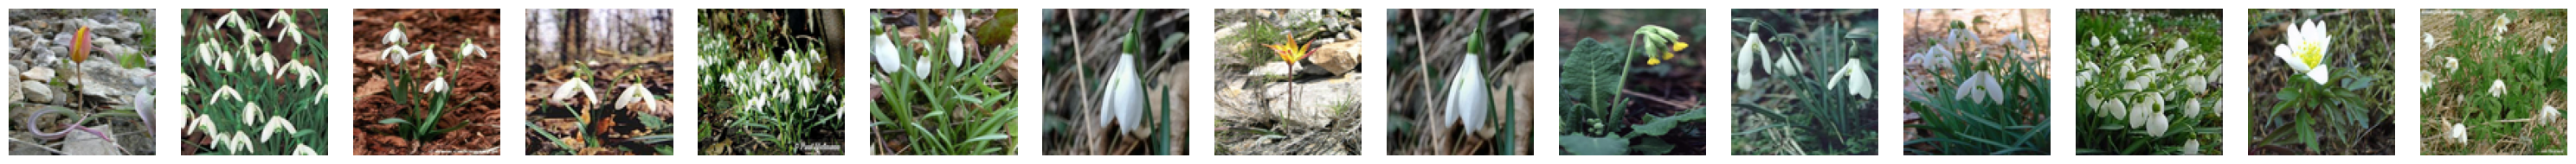

In [30]:
display_rk(rk_before)

**Configurar número de classes e gerar lista de rótulos (labels)**

In [10]:
dataset_size = len(dataset_elements)
class_size = 80
labels = [i//class_size for i in range(dataset_size)]

**Divisão do dataset em folds**

In [11]:
from sklearn.model_selection import StratifiedKFold

def fold_split(features, labels, n_folds=10):
    # Split in folds
    kf = StratifiedKFold(n_splits=n_folds, shuffle=False)
    res = kf.split(features, labels)
    return list(res)

In [12]:
# Split data in folds
folds = fold_split(features, labels, n_folds=10)

**Instalação do Pytorch Geometric**

In [13]:
# Primeiro, instalar o PyTorch
!pip install torch torchvision

# Verificar a versão do CUDA para instalar a versão correspondente do PyTorch Geometric
import torch
CUDA_VERSION = torch.version.cuda.replace('.', '')
print("Versão do CUDA:", CUDA_VERSION)

# Instalar o PyTorch Geometric
PYG_VERSION = '2.1.0'  # Escolha a versão de PyTorch Geometric que deseja instalar
TORCH_VERSION = torch.__version__.split('+')[0]

# Comandos para instalar o PyTorch Geometric e suas dependências
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-geometric=={PYG_VERSION}

Versão do CUDA: 121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html


**Definir o modelo de GCN**

In [14]:
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


class Net(torch.nn.Module):
    def __init__(self, pNFeatures, pNNeurons, numberOfClasses):
        super(Net, self).__init__()
        self.conv1 = GCNConv(pNFeatures, pNNeurons) #dataset.num_node_features
        self.conv2 = GCNConv(pNNeurons, numberOfClasses) #dataset.num_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

**Definir classe para configurar parâmetros e executar a GCN**

In [15]:
# Classe para classificação utilizando Grafos Convolucionais (GCN)
class GCNClassifier:
    def __init__(self, gcn_type, rks, pN, number_neighbors=40):
        """
        Inicializa o classificador GCN com os parâmetros necessários.

        Args:
            gcn_type (str): Tipo de GCN.
            rks (list): Lista de rankings para construção do grafo.
            pN (int): Número total de nós no grafo.
            number_neighbors (int): Número de vizinhos para construção do grafo KNN (default=40).
        """
        # Definição dos parâmetros e dispositivo (GPU ou CPU)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.pK = number_neighbors
        self.pN = pN
        self.rks = rks
        self.pLR = 0.001  # Taxa de aprendizado
        self.pNNeurons = 32  # Número de neurônios na camada oculta
        self.pNEpochs = 50  # Número de épocas de treinamento
        self.gcn_type = gcn_type

    def prepare(self, test_index, train_index, features, labels):
        """
        Prepara os dados para treinamento e validação.

        Args:
            test_index (list): Índices dos nós para teste.
            train_index (list): Índices dos nós para treinamento.
            features (list): Lista de features de entrada para os nós.
            labels (list): Lista de rótulos para os nós.
        """
        # Criação de máscaras para treinamento, validação e teste
        print('Creating masks ...')
        self.train_mask = [False] * self.pN
        self.val_mask = [False] * self.pN
        self.test_mask = [False] * self.pN

        for index in train_index:
            self.train_mask[index] = True
        for index in test_index:
            self.test_mask[index] = True

        # Conversão das máscaras para tensores PyTorch
        self.train_mask = torch.tensor(self.train_mask)
        self.val_mask = torch.tensor(self.val_mask)
        self.test_mask = torch.tensor(self.test_mask)

        # Definição dos rótulos
        print('Set labels ...')
        y = labels
        self.numberOfClasses = max(y) + 1
        self.y = torch.tensor(y).to(self.device)

        # Definição das features
        self.x = torch.tensor(features).to(self.device)
        self.pNFeatures = len(features[0])  # Número de features por nó

        # Construção do grafo
        self.create_graph()

    def create_graph(self):
        """
        Cria o grafo KNN com base nos rankings fornecidos.
        """
        print('Making edge list ...')
        self.top_k = self.pK
        edge_index = []

        # Construção da lista de arestas baseada nos rankings KNN
        for img1 in range(len(self.rks)):
            for pos in range(self.top_k):
                img2 = self.rks[img1][pos]
                edge_index.append([img1, img2])

        # Conversão da lista de arestas para formato PyTorch
        edge_index = torch.tensor(edge_index)
        self.edge_index = edge_index.t().contiguous().to(self.device)

    def train_and_predict(self):
        """
        Treina o modelo GCN e realiza a predição.

        Returns:
            embeddings (Tensor): Representações geradas pelo modelo.
            pred (list): Predições para os nós de teste.
        """
        # Criação do objeto de dados
        print('Loading data object...')
        data = Data(x=self.x.float(),             # features
                    edge_index=self.edge_index,   # graph
                    y=self.y,                     # labels
                    test_mask=self.test_mask,     # train/val/test split
                    train_mask=self.train_mask,
                    val_mask=self.val_mask)

        # Inicialização do modelo GCN
        model = Net(self.pNFeatures, self.pNNeurons, self.numberOfClasses).to(self.device)
        optimizer = torch.optim.Adam(model.parameters(), lr=self.pLR, weight_decay=5e-4)

        # Treinamento do modelo
        print('Training...')
        model.train()
        for epoch in range(self.pNEpochs):
            print(f"Training epoch: {epoch}")
            optimizer.zero_grad()
            out = model(data)
            data.y = torch.tensor(data.y, dtype=torch.long)  # Garantir que os rótulos estejam no tipo correto
            loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Cálculo da perda
            loss.backward()   # Backpropagation
            optimizer.step()  # Atualização dos pesos

        # Avaliação do modelo
        print('Evaluating...')
        model.eval()
        _, pred = model(data).max(dim=1)  # Obtém as predições
        pred = torch.masked_select(pred, data.test_mask)  # Seleciona apenas os nós de teste

        embeddings = model(data)  # Obtém as representações geradas pelo modelo

        return embeddings, pred.tolist()

In [16]:
clf = GCNClassifier("gcn-net", rks, len(labels),
                    number_neighbors=40)

In [17]:
for test_index, train_index in folds[:1]:
    clf.prepare(test_index, train_index, features, labels)
    embeddings, pred = clf.train_and_predict()

Creating masks ...
Set labels ...
Making edge list ...
Loading data object...
Training...
Training epoch: 0


<ipython-input-15-a48568c7ed7c>:108: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.y = torch.tensor(data.y, dtype=torch.long)  # Garantir que os rótulos estejam no tipo correto


Training epoch: 1
Training epoch: 2
Training epoch: 3
Training epoch: 4
Training epoch: 5
Training epoch: 6
Training epoch: 7
Training epoch: 8
Training epoch: 9
Training epoch: 10
Training epoch: 11
Training epoch: 12
Training epoch: 13
Training epoch: 14
Training epoch: 15
Training epoch: 16
Training epoch: 17
Training epoch: 18
Training epoch: 19
Training epoch: 20
Training epoch: 21
Training epoch: 22
Training epoch: 23
Training epoch: 24
Training epoch: 25
Training epoch: 26
Training epoch: 27
Training epoch: 28
Training epoch: 29
Training epoch: 30
Training epoch: 31
Training epoch: 32
Training epoch: 33
Training epoch: 34
Training epoch: 35
Training epoch: 36
Training epoch: 37
Training epoch: 38
Training epoch: 39
Training epoch: 40
Training epoch: 41
Training epoch: 42
Training epoch: 43
Training epoch: 44
Training epoch: 45
Training epoch: 46
Training epoch: 47
Training epoch: 48
Training epoch: 49
Evaluating...


In [18]:
embeddings.shape

torch.Size([1360, 17])

**Calcular acurácia no cojunto de teste**

In [19]:
# Obtém os rótulos dos nós de teste
test_labels = [labels[i] for i in test_index]

# Calcula a acurácia comparando predições com os rótulos verdadeiros
acc = 0  # Inicializa a variável de acurácia
for i in range(len(pred)):
    if test_labels[i] == pred[i]:  # Compara rótulo verdadeiro com a predição
        acc += 1  # Incrementa o contador se houver correspondência

# Calcula a acurácia como porcentagem
acc = acc / len(pred)  # Razão entre acertos e número total de predições
accuracy_percentage = acc * 100  # Converte para porcentagem

# Exibe o valor da acurácia
print(f"Acurácia: {accuracy_percentage:.2f}%")

Acurácia: 72.88%


**Visualização das Features Extraídas pela CNN VS Embeddings da GCN**

In [20]:
embeddings = embeddings.detach().numpy()

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_tsne(features, labels=None, perplexity=30, n_components=2, learning_rate=200, n_iter=1000):
    """
    Gera uma visualização 2D ou 3D dos vetores de características (features) utilizando t-SNE.

    Args:
        features (numpy.ndarray): Matriz de características com formato (n_samples, n_features).
        labels (numpy.ndarray ou list, opcional): Rótulos das amostras, usados para colorir os pontos. Default: None.
        perplexity (float, opcional): Parâmetro de perplexidade do t-SNE, relacionado ao número de vizinhos. Default: 30.
        n_components (int, opcional): Dimensionalidade do espaço t-SNE (2 para 2D, 3 para 3D). Default: 2.
        learning_rate (float, opcional): Taxa de aprendizado para o otimizador do t-SNE. Default: 200.
        n_iter (int, opcional): Número de iterações para otimização. Default: 1000.

    Returns:
        None: Exibe o gráfico t-SNE utilizando Matplotlib.
    """
    # Cria a instância do t-SNE e aplica a transformação
    tsne = TSNE(n_components=n_components, learning_rate=learning_rate, perplexity=perplexity, n_iter=n_iter)
    tsne_results = tsne.fit_transform(features)

    # Cria o gráfico
    plt.figure(figsize=(10, 8))

    if labels is not None:
        # Adiciona cores baseadas nos rótulos
        scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap='viridis', alpha=0.5)
        #plt.colorbar(scatter, label='Labels')  # Adiciona uma barra de cores para os rótulos
    else:
        # Gráfico sem rótulos
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha=0.5)

    # Configurações de estilo do gráfico
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('t-SNE Visualization of Feature Vectors')
    plt.tight_layout()  # Ajusta o layout para evitar cortes
    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


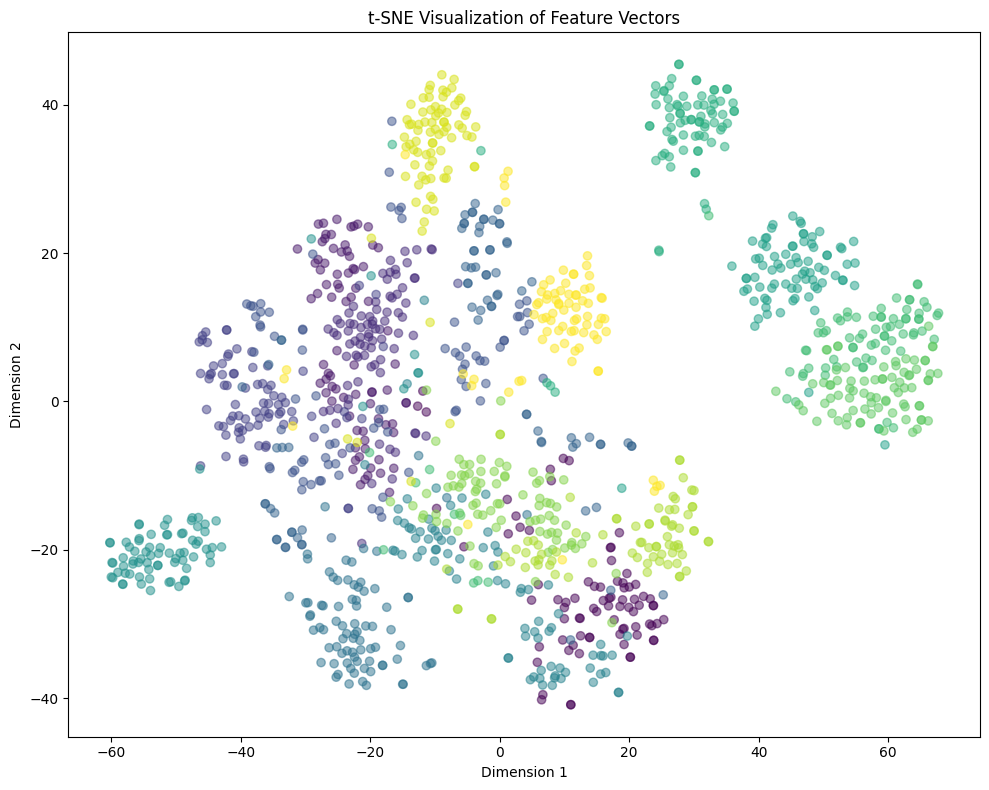

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


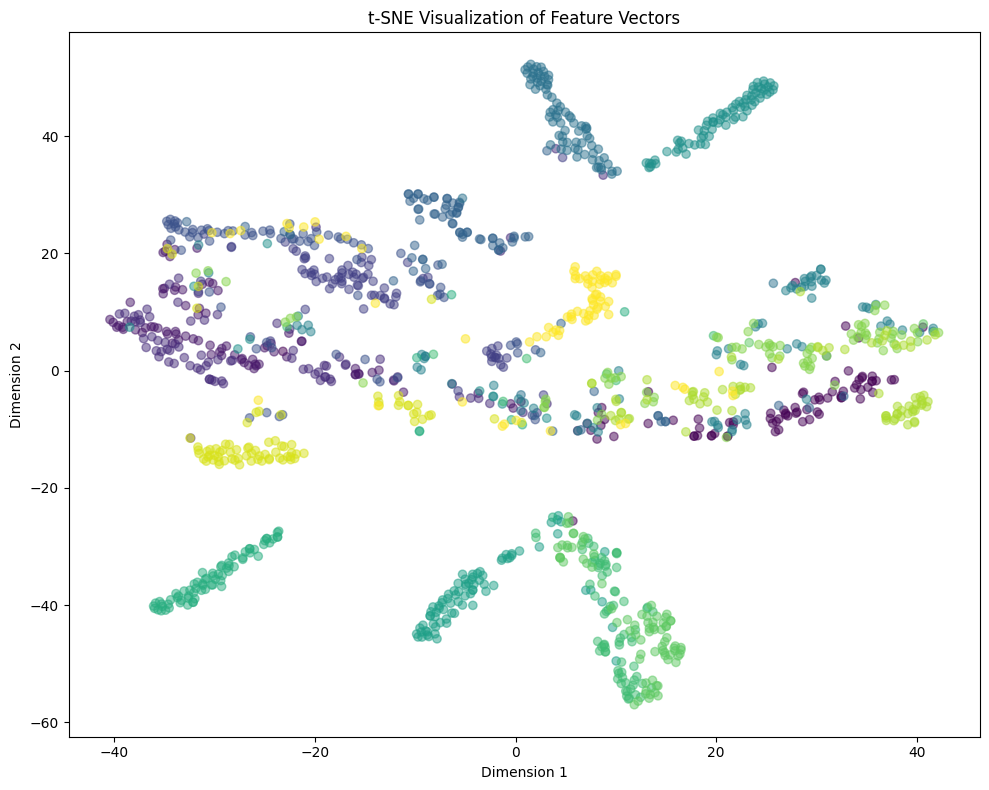

In [22]:
plot_tsne(features, labels)
plot_tsne(embeddings, labels)

In [23]:
!pip install umap-learn

In [24]:
import umap.umap_ as umap

def plot_umap(features, labels=None, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'):
    """
    Gera uma visualização 2D ou 3D dos vetores de características (features) utilizando UMAP.

    Args:
        features (numpy.ndarray): Matriz de características com formato (n_samples, n_features).
        labels (numpy.ndarray ou list, opcional): Rótulos das amostras, usados para colorir os pontos. Default: None.
        n_neighbors (int, opcional): Número de vizinhos para considerar na redução de dimensionalidade. Default: 15.
        min_dist (float, opcional): Distância mínima entre os pontos na projeção reduzida. Default: 0.1.
        n_components (int, opcional): Dimensionalidade do espaço UMAP (2 para 2D, 3 para 3D). Default: 2.
        metric (str, opcional): Métrica de distância a ser usada no UMAP. Default: 'euclidean'.

    Returns:
        None: Exibe o gráfico UMAP utilizando Matplotlib.
    """
    # Validações básicas
    if not isinstance(features, np.ndarray):
        raise ValueError("O argumento 'features' deve ser uma matriz NumPy.")
    if labels is not None and len(labels) != features.shape[0]:
        raise ValueError("O tamanho de 'labels' deve corresponder ao número de amostras em 'features'.")

    # Cria uma instância do UMAP e aplica a transformação
    umap_model = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, metric=metric)
    umap_results = umap_model.fit_transform(features)

    # Configuração para plot 2D ou 3D
    plt.figure(figsize=(12, 8))
    if n_components == 2:
        scatter = plt.scatter(umap_results[:, 0], umap_results[:, 1], c=labels, cmap='Spectral', s=50)
        plt.xlabel("UMAP Dimension 1", fontsize=14)
        plt.ylabel("UMAP Dimension 2", fontsize=14)
    elif n_components == 3:
        from mpl_toolkits.mplot3d import Axes3D
        ax = plt.figure().add_subplot(projection='3d')
        scatter = ax.scatter(umap_results[:, 0], umap_results[:, 1], umap_results[:, 2], c=labels, cmap='Spectral', s=50)
        ax.set_xlabel("UMAP Dimension 1", fontsize=14)
        ax.set_ylabel("UMAP Dimension 2", fontsize=14)
        ax.set_zlabel("UMAP Dimension 3", fontsize=14)
    else:
        raise ValueError("O valor de 'n_components' deve ser 2 ou 3.")

    # Adiciona a legenda se labels forem fornecidos
    #if labels is not None:
    #    plt.colorbar(scatter, label="Labels")

    plt.title('UMAP Projection', fontsize=18)
    plt.show()

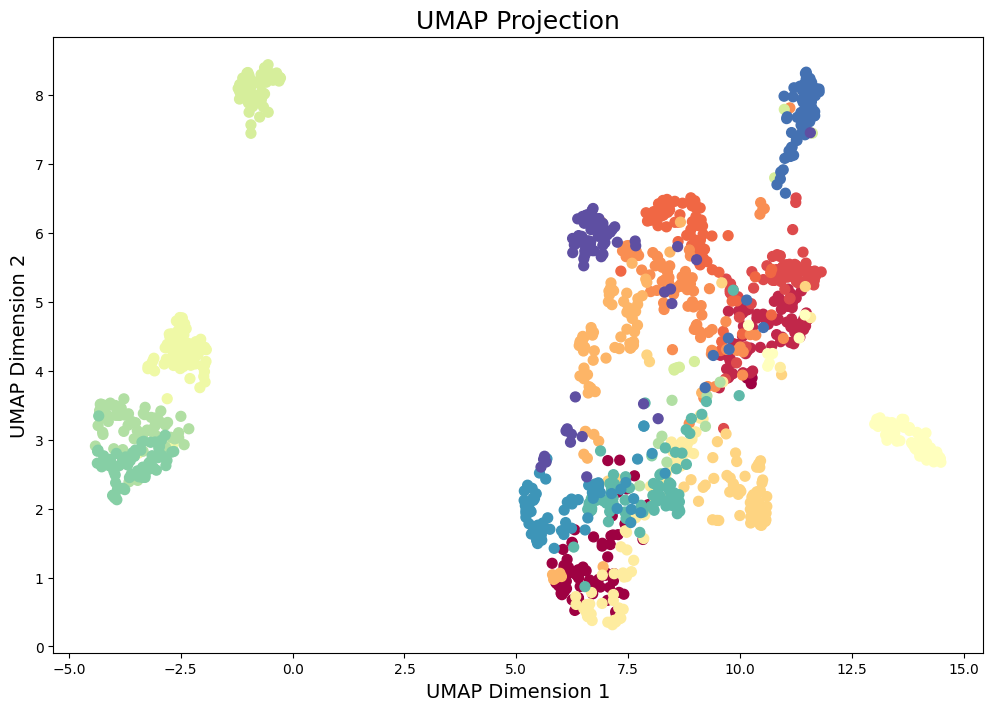

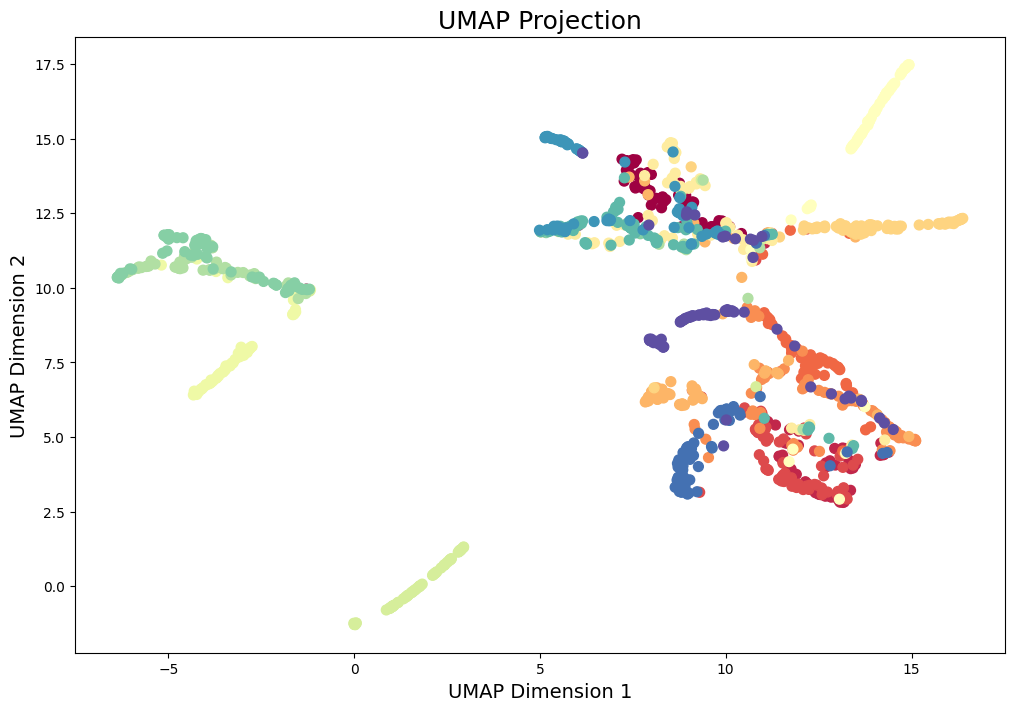

In [25]:
plot_umap(features, labels)
plot_umap(embeddings, labels)

**Cálculo de Listas Ranqueadas a partir dos Embeddings da GCN**

In [26]:
# Cálculo das listas ranqueadas a partir dos embeddings da GCN
new_rks = run_ball_tree(embeddings, k=100)

**Visualização das Listas Ranqueadas**

Comparação das listas ranqueadas antes e após a GCN.

In [27]:
def build_ranked_paths(imgs_dir, dataset_elements, rankings, query, top_n=15):
    return [imgs_dir + dataset_elements[img] for img in rankings[query][:top_n]]

imgs_dir = "/content/jpg/"
query = 600

rk_before = build_ranked_paths(imgs_dir, dataset_elements, rks, query)
rk_after = build_ranked_paths(imgs_dir, dataset_elements, new_rks, query)

In [28]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def display_rk(image_paths):
    # Define o número de imagens
    num_images = len(image_paths)

    # Cria uma figura e um conjunto de subplots
    fig, axes = plt.subplots(nrows=1, ncols=num_images, figsize=(num_images * 2, 2))

    # Garante que 'axes' seja uma lista para facilitar a iteração
    if num_images == 1:
        axes = [axes]

    # Carrega, redimensiona e exibe cada imagem
    for ax, img_path in zip(axes, image_paths):
        image = Image.open(img_path)
        image = image.resize((100, 100), Image.LANCZOS)  # Usa o filtro LANCZOS para alta qualidade
        ax.imshow(np.array(image))
        ax.axis('off')  # Desliga os eixos

    plt.tight_layout()
    plt.show()

In [29]:
display_rk(rk_before)
display_rk(rk_after)

Output hidden; open in https://colab.research.google.com to view.